In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data= pd.read_csv('/content/drive/MyDrive/train4.txt',delim_whitespace=True, header=0)

In [ ]:
data.head()

,Y,X,Z,INTENSITY,RETURN_NUM,RETURN_CNT,SCAN_DIR,FLT_EDGE,CLASS,SCAN_ANGLE,USER_DATA,SOURCE_ID,GPS_TIME,RED,GREEN,BLUE
0,5248540.453,524206.565,338.002,0,4,4,0,0,4,-3,0,0,0.0,59392,62976,4096
1,5248540.362,524206.630,339.202,16285,2,2,0,0,4,-3,0,0,0.0,59392,62976,4096
2,5248540.290,524206.644,339.270,7307,3,3,0,0,4,-3,0,0,0.0,59392,62976,4096
3,5248540.227,524206.665,339.515,19463,1,1,0,0,4,-3,0,0,0.0,59392,62976,4096
4,5248540.167,524206.685,339.772,8683,2,2,0,0,4,-3,0,0,0.0,59392,62976,4096


In [ ]:
features = data[['X', 'Y', 'Z', 'RED', 'GREEN', 'BLUE']].values

# Perform DBSCAN clustering
db = DBSCAN(eps=0.5, min_samples=20).fit(features)
labels = db.labels_

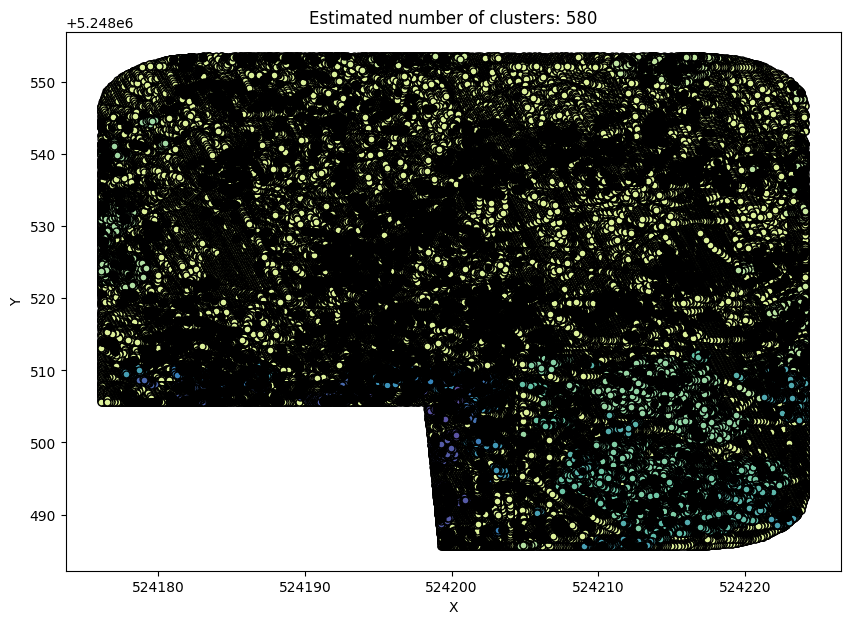

In [ ]:
# Number of clusters (excluding noise)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

plt.figure(figsize=(10, 7))
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:

        col = 'k'

    class_member_mask = (labels == k)

    xyz = data[['X', 'Y', 'Z']].values[class_member_mask]

    plt.plot(xyz[:, 0], xyz[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=5)

plt.title(f'Estimated number of clusters: {n_clusters}')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Plot each cluster individually in 3D
for cluster_id in range(n_clusters):
    cluster_points = data[labels == cluster_id]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(cluster_points['X'], cluster_points['Y'], cluster_points['Z'], c='b', marker='o')
    ax.set_title(f'Cluster {cluster_id}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

In [ ]:
# Create directory to save clusters
output_dir = 'clusters'
os.makedirs(output_dir, exist_ok=True)

for cluster_id in range(n_clusters):
    cluster_points = data[labels == cluster_id]
    file_path = os.path.join(output_dir, f'cluster_{cluster_id}.txt')
    cluster_points.to_csv(file_path, sep='\t', index=False)

print(f'Successfully saved {n_clusters} clusters in the {output_dir} directory.')

Successfully saved 580 clusters in the clusters directory.


In [ ]:
pip install laspy

In [ ]:
import laspy

In [ ]:
output_dir = 'clusters_las'
os.makedirs(output_dir, exist_ok=True)

for cluster_id in range(n_clusters):
    cluster_points = data[labels == cluster_id]

    header = laspy.LasHeader(point_format=3, version="1.2")
    las = laspy.LasData(header)

    las.x = cluster_points['X'].values
    las.y = cluster_points['Y'].values
    las.z = cluster_points['Z'].values
    las.red = cluster_points['RED'].values
    las.green = cluster_points['GREEN'].values
    las.blue = cluster_points['BLUE'].values

    file_path = os.path.join(output_dir, f'cluster_{cluster_id}.las')
    las.write(file_path)

print(f'Successfully saved {n_clusters} clusters in the {output_dir} directory.')

Successfully saved 580 clusters in the clusters_las directory.


In [ ]:
from google.colab import files
import shutil

shutil.make_archive('/content/cluster_las_data', 'zip', '/content/clusters_las')

files.download('/content/cluster_las_data.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from scipy.spatial import ConvexHull
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import pdist, squareform

In [ ]:
# Create directory to save clusters and extracted features
output_dir = 'cluster_las'
os.makedirs(output_dir, exist_ok=True)

features_list = []

for cluster_id in range(n_clusters):
    cluster_points = data[labels == cluster_id]

    # Extract features
    height = cluster_points['Z'].max() - cluster_points['Z'].min()

    crown_diameter = max(cluster_points['X'].max() - cluster_points['X'].min(),
                         cluster_points['Y'].max() - cluster_points['Y'].min())

    features_list.append({
        'cluster_id': cluster_id,
        'height': height,
        'crown_diameter': crown_diameter,
    })

    header = laspy.LasHeader(point_format=3, version="1.2")
    las = laspy.LasData(header)

    las.x = cluster_points['X'].values
    las.y = cluster_points['Y'].values
    las.z = cluster_points['Z'].values
    las.red = cluster_points['RED'].values
    las.green = cluster_points['GREEN'].values
    las.blue = cluster_points['BLUE'].values

    file_path = os.path.join(output_dir, f'cluster_{cluster_id}.las')
    las.write(file_path)

# Create a DataFrame for the extracted features
features_df = pd.DataFrame(features_list)
features_df.to_csv('extracted_features.csv', index=False)

print(f'Successfully saved {n_clusters} clusters in the {output_dir} directory and extracted features to extracted_features.csv')

Successfully saved 580 clusters in the cluster_las directory and extracted features to extracted_features.csv


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Load the extracted features
features_df = pd.read_csv('extracted_features.csv')

np.random.seed(42)
features_df['is_tree'] = np.random.choice([0, 1], size=len(features_df))

X = features_df[['height', 'crown_diameter']]
y = features_df['is_tree']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

model_path = 'tree_detection_model.joblib'
joblib.dump(clf, model_path)

print(f'Model saved to {model_path}')

Accuracy: 0.5057471264367817
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.54      0.50        80
           1       0.55      0.48      0.51        94

    accuracy                           0.51       174
   macro avg       0.51      0.51      0.51       174
weighted avg       0.51      0.51      0.51       174

Model saved to tree_detection_model.joblib


In [ ]:
# Adding more features like volume and canopy area
features_df['volume'] = features_df['height'] * features_df['crown_diameter']**2
features_df['canopy_area'] = np.pi * (features_df['crown_diameter'] / 2)**2

X = features_df[['height', 'crown_diameter', 'volume', 'canopy_area']]
y = features_df['is_tree']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
#Trying Different Algorithms

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# Try RandomForest
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForest Accuracy:', accuracy_score(y_test, rf_pred))
print('RandomForest Classification Report:')
print(classification_report(y_test, rf_pred))

# Try SVM
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)
print('SVM Accuracy:', accuracy_score(y_test, svm_pred))
print('SVM Classification Report:')
print(classification_report(y_test, svm_pred))

# Try GradientBoosting
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
print('GradientBoosting Accuracy:', accuracy_score(y_test, gb_pred))
print('GradientBoosting Classification Report:')
print(classification_report(y_test, gb_pred))

RandomForest Accuracy: 0.46551724137931033
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.47      0.45        80
           1       0.51      0.46      0.48        94

    accuracy                           0.47       174
   macro avg       0.47      0.47      0.47       174
weighted avg       0.47      0.47      0.47       174

SVM Accuracy: 0.5402298850574713
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.54      1.00      0.70        94

    accuracy                           0.54       174
   macro avg       0.27      0.50      0.35       174
weighted avg       0.29      0.54      0.38       174

GradientBoosting Accuracy: 0.5344827586206896
GradientBoosting Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.60      0.54        80
           1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
